In [61]:
import nilearn
from nilearn.input_data import NiftiMapsMasker, NiftiLabelsMasker
from nilearn import datasets, plotting
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numba import jit
import warnings
warnings.filterwarnings('ignore')

plt.style.use("~/.config/matplotlib/custom")

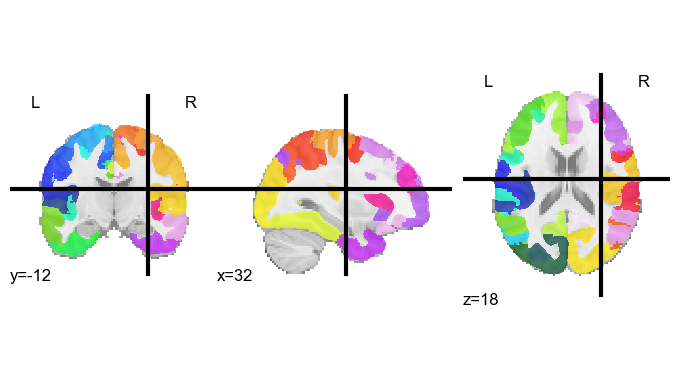

In [51]:
lsd = '/home/ilkin/Documents/GitHub/datasci/fmri/data/sub-001/ses-LSD/func/sub-001_ses-LSD_task-rest_run-01_bold.nii.gz'
plc = '/home/ilkin/Documents/GitHub/datasci/fmri/data/sub-001/ses-PLCB/func/sub-001_ses-PLCB_task-rest_run-01_bold.nii.gz'

n_roi = 400
atlas = datasets.fetch_atlas_schaefer_2018()
plotting.plot_roi(atlas.maps)

In [52]:
masker = NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)
lsds = masker.fit_transform(lsd)
plcs = masker.fit_transform(plc)
np.save('ints/lsd_ts', lsds)
np.save('ints/plc_ts', plcs)
lsds.shape, plcs.shape

((217, 400), (217, 400))

In [70]:
def ret_pears(timeseries):
    pears_mat = np.zeros((n_roi, n_roi))
    # score_mat = np.zeros_like(pears_mat)
    for i in range(n_roi):
        for j in range(i+1, n_roi):
            statistic = scipy.stats.pearsonr((timeseries[:, i]), (timeseries[:, j]))
            pears_mat[i, j] = statistic[0]
            # score_mat[i, j] = statistic[1]
    return pears_mat

lsd_pears = ret_pears(lsds)
plc_pears = ret_pears(plcs)

Text(0.5, 1.0, 'lsd (top right) vs plc (bottom left)')

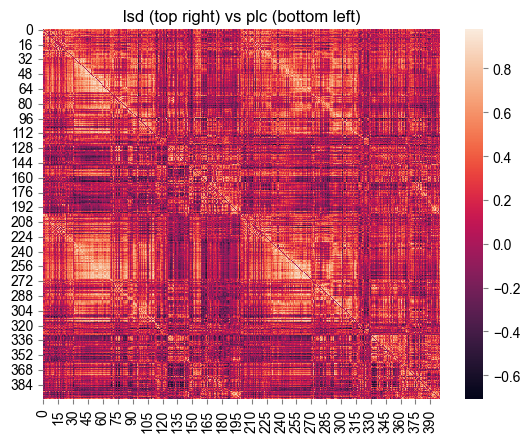

In [72]:
sns.heatmap(lsd_pears + plc_pears.T)
plt.title('lsd (top right) vs plc (bottom left)')

In [73]:
def nan_streak(mat):
    mat = mat + mat.T
    for i in range(n_roi):
        mat[i, i] = np.nan
    return mat

lsd_mat = nan_streak(lsd_pears)
plc_mat = nan_streak(plc_pears)

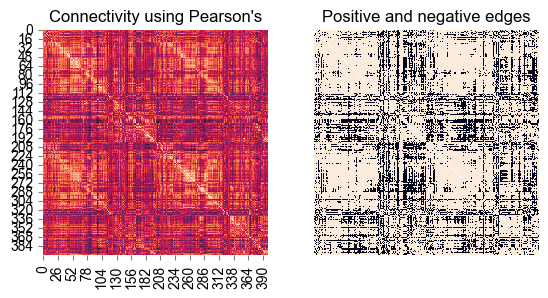

In [10]:
fig, ax = plt.subplots(1, 2)
ax[0].set_aspect('equal')
ax[0].set_yticklabels([])
ax[0].set_title("Connectivity using Pearson's")
ax[1].set_title("Positive and negative edges")
ax[1].set_aspect('equal')
sns.heatmap(mat, ax=ax[0], cbar=False)
sns.heatmap(np.ceil(mat) * 2 -1, ax=ax[1], cbar=False)
plt.axis('off')
plt.show()

In [74]:
@jit
def ret_frus(mat):
    prod_mat = np.zeros((n_roi, n_roi, n_roi))
    for i in range(n_roi):
        for j in range(i+1, n_roi):
            for k in range(j+1, n_roi):
                prod = mat[i,j]*mat[i,k]*mat[j,k]
                prod_mat[i, j, k] = prod
                prod_mat[i, k, j] = prod
                prod_mat[j, i, k] = prod
                prod_mat[j, k, i] = prod
                prod_mat[k, j, i] = prod
                prod_mat[k, i, j] = prod
    return prod_mat
lsd_prod = ret_frus(lsd_mat)
plc_prod = ret_frus(plc_mat)

In [75]:
lsd_bin, plc_bin = lsd_prod < 0, plc_prod < 0

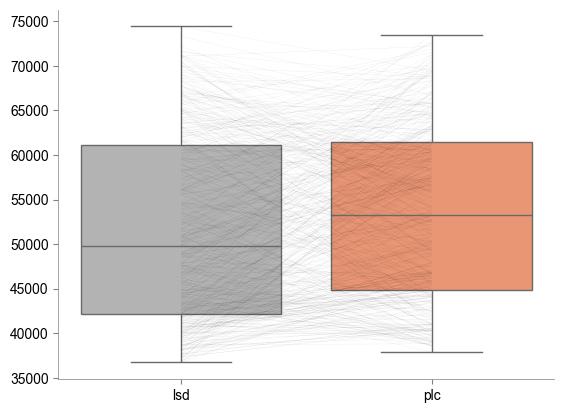

In [90]:
df = pd.DataFrame()
df['lsd'] = lsd_bin.sum(0).sum(0)
df['plc'] = plc_bin.sum(0).sum(0)
sns.boxplot(df)
for i in range(n_roi):
    plt.plot((0, 1), (df['lsd'][i], df['plc'][i]), 'k', alpha=0.2, linewidth=0.1)

(array([ 3., 19., 28., 45., 96., 78., 59., 42., 23.,  7.]),
 array([-32486. , -26638.6, -20791.2, -14943.8,  -9096.4,  -3249. ,
          2598.4,   8445.8,  14293.2,  20140.6,  25988. ]),
 <BarContainer object of 10 artists>)

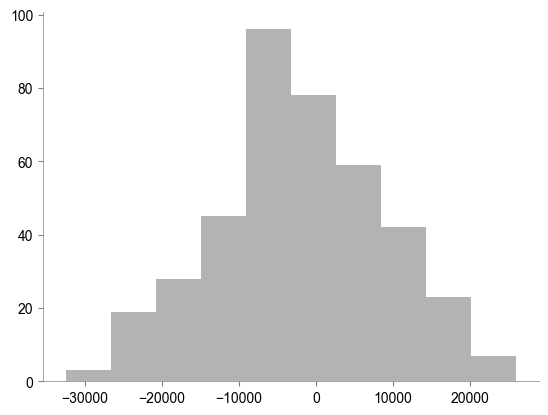

In [91]:
plt.hist(lsd_bin.sum(0).sum(0) - plc_bin.sum(0).sum(0))

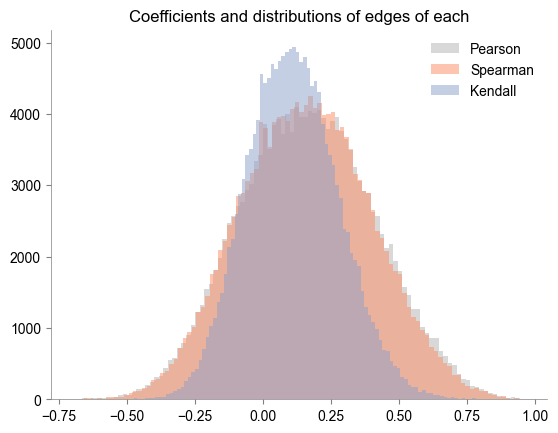

In [156]:

for i, j in zip([pears_mat, spear_mat, kendt_mat], ['Pearson', 'Spearman', 'Kendall']):
    plt.hist((i).flatten(), bins=100, alpha=0.5, label=j)
plt.title('Coefficients and distributions of edges of each')
plt.legend()
plt.show()

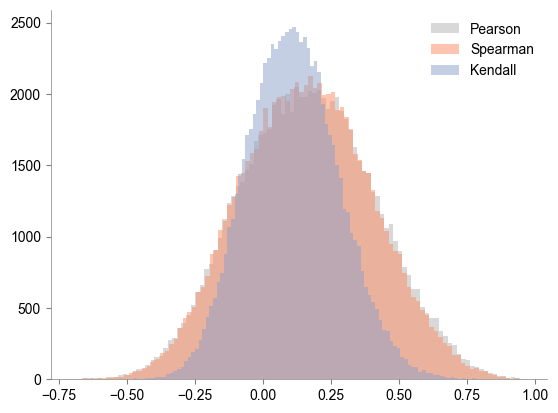

In [81]:
pears_list = []
spear_list = []
kendt_list = []
for i, j, k in zip(pears, spear, kendt):
    pears_list += i
    spear_list += j
    kendt_list += k
for i, j in zip([pears_list, spear_list, kendt_list], ['Pearson', 'Spearman', 'Kendall']):
    plt.hist(i, bins=100, alpha=0.5, label=j)
plt.legend()
plt.show()